In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import yasa
import pandas as pd
import mne

from pathlib import Path
import matplotlib.pyplot as plt 

In [10]:
# Load data from EDF file
p = Path.cwd().parent / "data"

edf_files = sorted(p.glob('*/*.edf'))

d1 = edf_files[0]
pt1 = d1.parent.name

### load raw data

In [11]:
raw = mne.io.read_raw_edf(d1, preload=True)

Extracting EDF parameters from C:\Users\sijmn\Documents\allProjectsCode\circadian_eeg\data\N1\Cortisleep1_2023-02-08T19-24-23[+0100].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11215749  =      0.000 ... 44862.996 secs...


In [22]:
raw.__dir__()

['_last_samps',
 '_first_samps',
 'info',
 'buffer_size_sec',
 '_cals',
 '_raw_extras',
 '_read_picks',
 '_read_comp_grade',
 '_comp',
 '_filenames',
 'orig_format',
 '_orig_units',
 '_projectors',
 '_projector',
 '_dtype_',
 '_annotations',
 '_cropped_samp',
 '_data',
 'preload',
 '_init_kwargs',
 '__module__',
 '__doc__',
 '__init__',
 '_read_segment_file',
 '_extra_attributes',
 'apply_gradient_compensation',
 '_dtype',
 '_read_segment',
 '_check_bad_segment',
 'load_data',
 '_preload_data',
 '_first_time',
 'first_samp',
 'first_time',
 'last_samp',
 '_last_time',
 'time_as_index',
 '_raw_lengths',
 'annotations',
 'filenames',
 'set_annotations',
 '__del__',
 '__enter__',
 '__exit__',
 '_parse_get_set_params',
 '__getitem__',
 '_getitem',
 '__setitem__',
 'get_data',
 'apply_function',
 'filter',
 'notch_filter',
 'resample',
 'crop',
 'crop_by_annotations',
 'save',
 'export',
 '_tmin_tmax_to_start_stop',
 'plot',
 'ch_names',
 'times',
 'n_times',
 '__len__',
 'load_bad_channels

In [61]:
data = raw.get_data()
fs = raw.info['sfreq']
d = raw.get_data()
# raw.ch_names
x = raw.filter(0.3, 45)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 2751 samples (11.004 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.3s finished


### plot hypnogram

In [79]:
hypnogram_data

Time [hh:mm:ss]
1900-01-01 00:00:23    WAKE
1900-01-01 00:00:53    WAKE
1900-01-01 00:01:23    WAKE
1900-01-01 00:01:53    WAKE
1900-01-01 00:02:23    WAKE
                       ... 
1900-01-01 23:57:53     REM
1900-01-01 23:58:23     REM
1900-01-01 23:58:53     REM
1900-01-01 23:59:23     REM
1900-01-01 23:59:53     REM
Name: Sleep Stage, Length: 1495, dtype: category
Categories (4, object): ['REM', 'WAKE', 'N1', 'N2']

C:\Users\sijmn\anaconda3\envs\mydre_env\lib\site-packages\yasa\hypno.py:483: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  return self.hypno.replace(self.mapping).astype(np.int16)


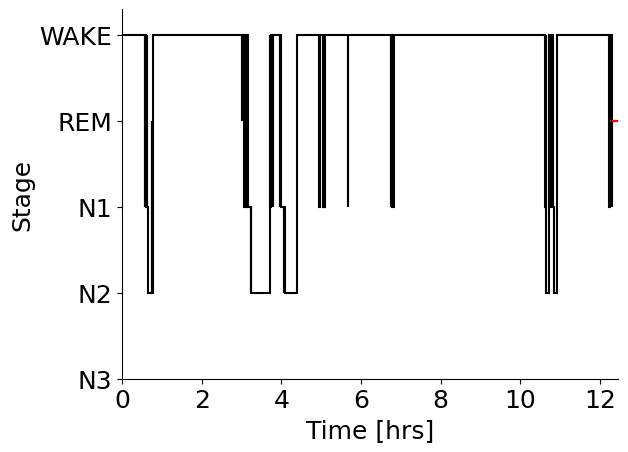

In [74]:
# Load hypnogram data
pd.set_option('future.no_silent_downcasting', True)


start_index = 0
for i, line in enumerate(hd):
    if line.startswith('Sleep Stage'):
        start_index = i + 1
        break

# Extract the column headers and rows
columns = hd[start_index - 1].strip().split('\t')
rows = [line.strip().split('\t') for line in hd[start_index:] if line.strip()]

hypno = pd.DataFrame(rows, columns=columns)

# Strip any extra spaces from column names
hypno.columns = hypno.columns.str.strip()

# Convert 'Sleep Stage' column to a categorical type
hypno['Sleep Stage'] = hypno['Sleep Stage'].astype('category')

# Define the mapping for sleep stages to string values
stage_mapping = {
    'SLEEP-S0': 'WAKE',
    'SLEEP-S1': 'N1',
    'SLEEP-S2': 'N2',
    'SLEEP-S3': 'N3',
    'SLEEP-REM': 'REM'
}


# Convert 'Sleep Stage' column to a categorical type
hypno['Sleep Stage'] = hypno['Sleep Stage'].astype('category')

# Use rename_categories to change the categories
hypno['Sleep Stage'] = hypno['Sleep Stage'].cat.rename_categories(stage_mapping)

# Convert the 'Time [hh:mm:ss]' column to a datetime format
hypno['Time [hh:mm:ss]'] = pd.to_datetime(hypno['Time [hh:mm:ss]'], format='%H:%M:%S')

# Set the 'Time [hh:mm:ss]' column as the index
hypno.set_index('Time [hh:mm:ss]', inplace=True)

# Ensure the DataFrame is sorted by the index
hypno.sort_index(inplace=True)

# Extract the 'Sleep Stage' column as a pandas Series
hypnogram_data = hypno['Sleep Stage']

# Create a Hypnogram object with the data
hypnogram = yasa.Hypnogram(hypnogram_data)

hypnogram.plot_hypnogram()
plt.show()

In [87]:
hypno

,Sleep Stage,Event,Duration[s]
Time [hh:mm:ss],,,
1900-01-01 00:00:23,WAKE,SLEEP-S0,30
1900-01-01 00:00:53,WAKE,SLEEP-S0,30
1900-01-01 00:01:23,WAKE,SLEEP-S0,30
1900-01-01 00:01:53,WAKE,SLEEP-S0,30
1900-01-01 00:02:23,WAKE,SLEEP-S0,30
...,...,...,...
1900-01-01 23:57:53,REM,SLEEP-REM,30
1900-01-01 23:58:23,REM,SLEEP-REM,30
1900-01-01 23:58:53,REM,SLEEP-REM,30


In [14]:
stage_mapping = {
    'SLEEP-S0': 0,
    'SLEEP-S1': 1,
    'SLEEP-S2': 2,
    'SLEEP-S3': 3,
    'SLEEP-REM': 4
}

hypno['Event'] = hypno['Event'].astype('category')
hypno['Event'] = hypno['Event'].cat.rename_categories(stage_mapping)

yasa.sleep_statistics(hypno['Event'].values, sf_hyp=1/30)

{'TIB': 747.5,
 'SPT': 713.5,
 'WASO': 604.0,
 'TST': 109.5,
 'N1': 31.5,
 'N2': 64.5,
 'N3': 0.0,
 'REM': 13.5,
 'NREM': 96.0,
 'SOL': 34.0,
 'Lat_N1': 34.0,
 'Lat_N2': 39.5,
 'Lat_N3': nan,
 'Lat_REM': 45.0,
 '%N1': 28.767123287671232,
 '%N2': 58.9041095890411,
 '%N3': 0.0,
 '%REM': 12.32876712328767,
 '%NREM': 87.67123287671232,
 'SE': 14.648829431438127,
 'SME': 15.3468815697267}

### In "data" 
['Accelero Norm',
 'EEG F7-O1',
 'EEG F8-O2',
 'EEG F8-F7',
 'EEG F8-O1',
 'EEG F7-O2',
 'Positiongram',
 'Respiration x',
 'Respiration y',
 'Respiration z']

In [83]:
data_f1o1 = data[1, :]
data_f8o2 = data[2, :]
data_f8f7 = data[3, :]
data_f8o1 = data[4, :]
data_f7o2 = data[5, :]

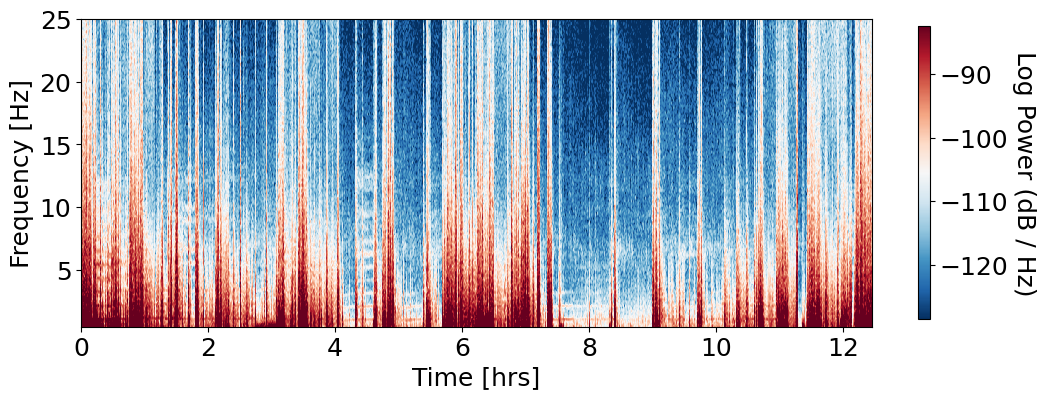

In [85]:
fig = yasa.plot_spectrogram(data_f1o1, fs)

C:\Users\sijmn\anaconda3\envs\mydre_env\lib\site-packages\yasa\hypno.py:483: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



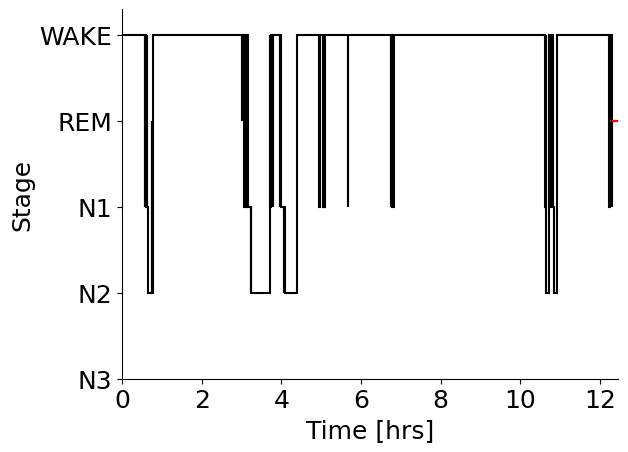

In [86]:
hypnogram.plot_hypnogram()
plt.show()